# OpenFOAM and Pytorch
The exercise notebook is [exercise 04/05](../notebooks/ml_intro_exercise.ipynb) in the exercises folder.

## Part 1: Creating a parameter study with OpenFOAM and PyTorch
The Simulation is a 1D channel flow.

1. How many Cells?
 - 200
2. Boundary Conditions for U?
 - Inlet & Outlet (Left & Right): cyclic
 - Bottom : fixedValue (0 0 0) -> no slip (Haftbedingung)
 - Top: symmetryPlane -> only observe half of the channel because the flow is symmetric
 - back and front (z direction): empty -> 2D simulation
3. Driving Force / Source Term (Impulsquelle)?
 - meanVelocityForce for VectorField U with a mean velocity of (0.5 0 0)
 - selectionMode = all -> apply the force to all cells
 - that means every cells has the same velocity of 0.5 m/s in x direction

$$
U_{mean,current}  = \frac{1}{V} \int_{V} U \, dV
$$

4. Reynolds Number

$$
Re = \frac{U_{\text{mean}} \, H}{\nu}
$$

- $$ U_{\text{mean}} = 0.5 \, \text{m/s} $$
- $$ H = 0.1 \, \text{m} $$
- $$ \nu = 1\times10^{-3} \, \text{m}^2/\text{s} $$

ergibt sich:
$$
Re = \frac{0.5 \cdot 0.1}{1\times10^{-3}} = 50
$$

Durch Verdoppeln von $ U_{\text{mean}} = 1.0 \, \text{m/s} $ wird $ Re = 100 $

5. Time Step and Courant Number
Für Stabilität gilt der **Courant-Kriterium**:

$$
Co = \frac{U \, \Delta t}{\Delta x} \le 0.5
$$

Mit:
- $$ \Delta x = 0.01 \, \text{m} $$
- $$ U = 1.0 \, \text{m/s} $$

folgt:
$$
\Delta t \le \frac{Co \cdot \Delta x}{U} = \frac{0.5 \cdot 0.01}{1} = 0.005 \, \text{s}
$$

Wir wählen:
$$
\Delta t = 0.0025 \, \text{s}
$$

6. Dimensionless Time
Die **dimensionslose Zeit** ist definiert als:

$$
t^* = \frac{t \, U_{\text{mean}}}{2\delta}
$$

Mit:
- $$ 2\delta = 1 \, \text{m} $$
- $$ U_{\text{mean}} = 1.0 \, \text{m/s} $$

ergibt sich:
$$
t^* = \frac{1 \cdot 1}{1} = 1
$$

→ Für $$ t = 1\,\text{s} $$ gilt $$ t^* = 1 $$.  
Die Simulation läuft also bis **endTime = 1 s**.

### Performing the Parameter Variation
To perform the parameter variation, we will use a Python script that modifies the OpenFOAM case files and runs the simulations for different values of kinematic viscosity (nu). The script will also collect the results for further analysis with PyTorch.

1. How many simulations will be performed in total?
```bash
ubar = lhs_sampling([0.1], [1.0], 16).squeeze()
```
- we vary the mean velocity from 0.1 m/s to 1.0 m/s in 16 steps so that we get different Reynolds numbers -> 16 Simulations in total

2. How many simulations are performed at the same time?
```bash
pool = Pool(8)
with pool:
    pool.map(run_simulation, cases)
```
- 8 simulations are performed at same time using multiprocessing

3. Which parameters in which file of the base setup are modified?
```bash
    for ub in ubar:
        replace = (
            ("system/controlDict", "^endTime.*", "endTime" + " "*9 + "{:1.0f};".format(50.0/ub.item())),
            ("system/controlDict", "^deltaT.*", "deltaT" + " "*10 + "{:1.1e};".format(1.0e-3/ub.item())),
            ("system/fvOptions", ".*Ubar.*", " "*4 + "Ubar" + " "*12 + "({:1.4f} 0 0);".format(ub.item()))
        )
```
- mean velocity in **system/fvOptions**
- endTime and deltaT in **system/controlDict**

4. Where are the modified simulations stored?
- in the folder **boundary_layer_1D_variation/**

[2025-11-12 08:50:17] WARNING  Could not find precomputed cell centers and volumes.
Computing cell geometry from scratch (slow, not recommended for large meshes).
To compute cell centers and volumes in OpenFOAM, run:

postProcess -func "writeCellCentres" -constant -time none
postProcess -func "writeCellVolumes" -constant -time none


Shape of data matrix:  torch.Size([200, 16])


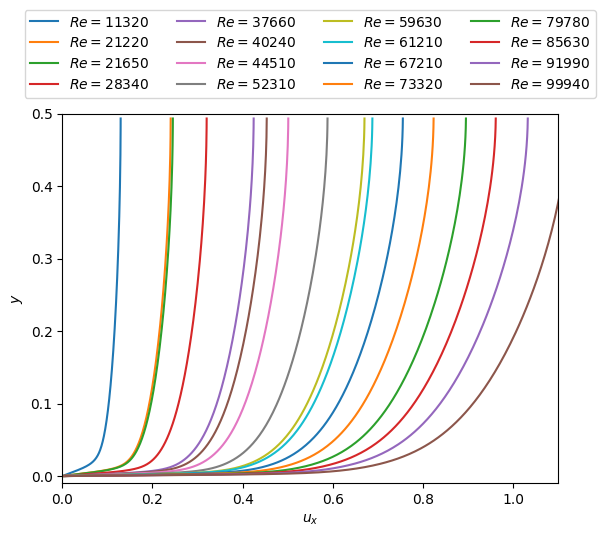

In [1]:
from glob import glob
from os.path import join
import torch as pt
import matplotlib.pyplot as plt
from flowtorch.data import FOAMDataloader

#
# adjust the path if necessary
#
cases = glob("./boundary_layer_1D_variation/Ub_*")

cases = sorted(cases, key=lambda case: float(case.split("_")[-1]))
loader = FOAMDataloader(cases[0])
y = loader.vertices[:, 1]
u_x = pt.zeros((y.shape[0], len(cases)))
for i, case in enumerate(cases):
    loader = FOAMDataloader(case)
    u_x[:, i] = loader.load_snapshot("U", loader.write_times[-1])[:, 0]

Ubar = pt.tensor([float(case.split("_")[-1]) for case in cases])
print("Shape of data matrix: ", u_x.shape)

# creating a plot
delta, nu = 0.5, 1.0e-5
Re = pt.tensor([Ub.item()*2*delta/nu for Ub in Ubar])
for i, Ub in enumerate(Ubar):
    plt.plot(u_x[:, i], y, label=r"$Re={:1.0f}$".format(round(Re[i].item(), 0)))
plt.xlabel(r"$u_x$")
plt.ylabel(r"$y$")
plt.xlim(0.0, 1.1)
plt.ylim(-0.01, 0.5)
plt.legend(loc="upper center", ncol=4, bbox_to_anchor=[0.5, 1.3])
plt.show()